In [2]:
import networkx as nx
from biological_fuzzy_logic_networks.utils import read_sif
from biological_fuzzy_logic_networks.draw import draw_BioFuzzNet
import pandas as pd

/Users/adr/miniconda3/envs/biofuzznet/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cl_data = pd.read_csv("/Users/adr/Box/CAR_Tcells/Data/DREAMdata/ZR7530.csv")
print(cl_data.columns)

Index(['treatment', 'cell_line', 'time', 'cellID', 'fileID', 'b.CATENIN',
       'cleavedCas', 'CyclinB', 'GAPDH', 'IdU', 'Ki.67', 'p.4EBP1',
       'p.Akt.Ser473.', 'p.AKT.Thr308.', 'p.AMPK', 'p.BTK', 'p.CREB', 'p.ERK',
       'p.FAK', 'p.GSK3b', 'p.H3', 'p.HER2', 'p.JNK', 'p.MAP2K3', 'p.MAPKAPK2',
       'p.MEK', 'p.MKK3.MKK6', 'p.MKK4', 'p.NFkB', 'p.p38', 'p.p53',
       'p.p90RSK', 'p.PDPK1', 'p.PLCg2', 'p.RB', 'p.S6', 'p.S6K', 'p.SMAD23',
       'p.SRC', 'p.STAT1', 'p.STAT3', 'p.STAT5'],
      dtype='object')


In [5]:
nodes, edges = read_sif("/Users/adr/Box/CAR_Tcells/Data/DREAMdata/PKN_Alice.sif")
# edges[("JNK", "p53")] = 1

In [6]:
G = nx.DiGraph()
G.add_edges_from(edges)

In [7]:
measured_nodes = ["PLCg2", "SRC", "FAK", "BTK", "STAT1", "STAT3", "STAT5", "PDPK1", 
                  "AKT", "AKT_S473", "AKT_T308", "GSK3B", "b-catenin", "NFkB", "AMPK", 
                  "4EBP1", "p70S6K", "S6", "MEK12", "MEK12_S221", "ERK12", "p90RSK", 
                  "CREB", "MKK4", "JNK", "p53", "RB", "MKK36", "p38", "MAPKAPK2", "cleavedCas", 
                  "H3", "SMAD23", "MAP3Ks"]
atrr_dict = {node: {"measured": True} if node in measured_nodes else {"measured": False} for node in G.nodes()}
nx.set_node_attributes(G, atrr_dict)

In [8]:
SC1_nodes = ["ERK12", "PLCg2", "S6", "AKT_S473"] # HER2 not in the network...?

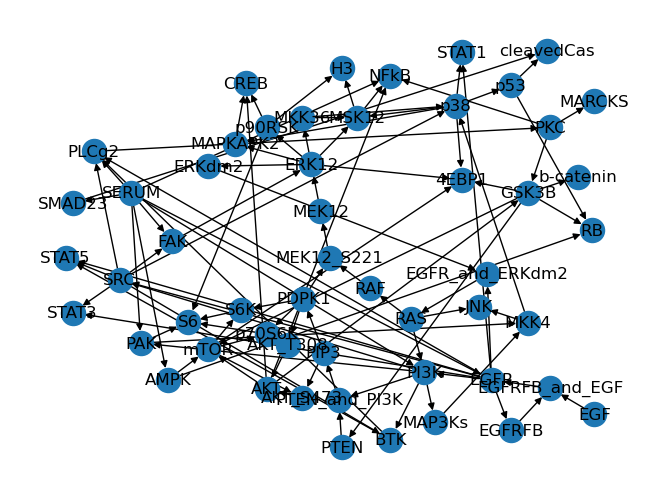

In [9]:
nx.draw(G, pos=nx.drawing.nx_agraph.graphviz_layout(G, prog="twopi") , with_labels=True)

In [10]:
[n for n in measured_nodes if not n in G.nodes()]

[]

In [12]:
def check_measured_parents(node, sel_nodes=[]):
    print(node)
    parents = list(G.predecessors(node))
    if len(parents) == 0:
        raise Exception('Not possible to have measured input nodes')
    else:
        for p in parents:
            if p==node:
                continue
            if G.nodes[p]['measured']:
                sel_nodes.append(p)
            else:
                check_measured_parents(p, sel_nodes)
        return sel_nodes
            

In [13]:
check_measured_parents("S6")

S6
S6K
mTOR
PAK
PI3K
SERUM


Exception: Not possible to have measured input nodes

In [16]:
for node in SC1_nodes:
    print(node)
    try:
        print(check_measured_parents(node))
    except:
        continue

ERK12
ERK12
['AMPK', 'GSK3B', 'AKT', 'PDPK1', 'p90RSK', 'MEK12', 'FAK', 'AMPK', 'GSK3B', 'AKT', 'PDPK1', 'p90RSK', 'GSK3B', 'MEK12', 'FAK']
PLCg2
PLCg2
SERUM
S6
S6
S6K
mTOR
PAK
PI3K
SERUM
AKT_S473
AKT_S473
PIP3
PTEN_and_PI3K
PTEN
PI3K
SERUM


In [ ]:
nx.get_node_attributes(G, "measured")

In [ ]:
G["STAT3"]

In [17]:
for node in measured_nodes:

    parents= list(G.predecessors(node))
    
    # Check if all parents are not measured
    if (len(parents)-sum([G.nodes[p]['measured'] for p in parents]) == len(parents)):
        print(node)

SRC
PDPK1
AKT_S473
AMPK
SMAD23
MAP3Ks


Would it be possible, to have the input (SERUM=1 and EGF=1) but then when all upstream nodes are not measured we use the single cell values. So we remove the upstream interactions there and include the SRC, PDPK1, AKT_S473, AMPK, SMAD23 and MAP3Ks as root nodes. To include single cell variability in the network

SRC downstream of EGFR and PI3K both not measured but they are perturbed, so this might leak information... <br>
PDKP1 only downstream of PIP3, which is downstream of PI3K and EGFR <br>
AKT_S473 downstream of mTOR and PIP3 so downstream of perturbations PI3K, EGFR and mTOR <br>
AMPK, SMAD23 only downstream of SERUM :) <br>
MAP3Ks downstream of PI3K and thus downstream of perturbations PI3K and EGFR <br>